In [1]:
import requests
import simplejson as json
import pandas as pd
import urllib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
from joblib import Parallel, delayed

#install from https://github.com/akeshavan/braindr-analysis 
#(pip install git+https://github.com/akeshavan/braindr-analysis)
import braindrAnalysis as ba
%matplotlib inline

Failed to import duecredit due to No module named 'duecredit'
Using TensorFlow backend.


## Mindcontrol Rating Scale

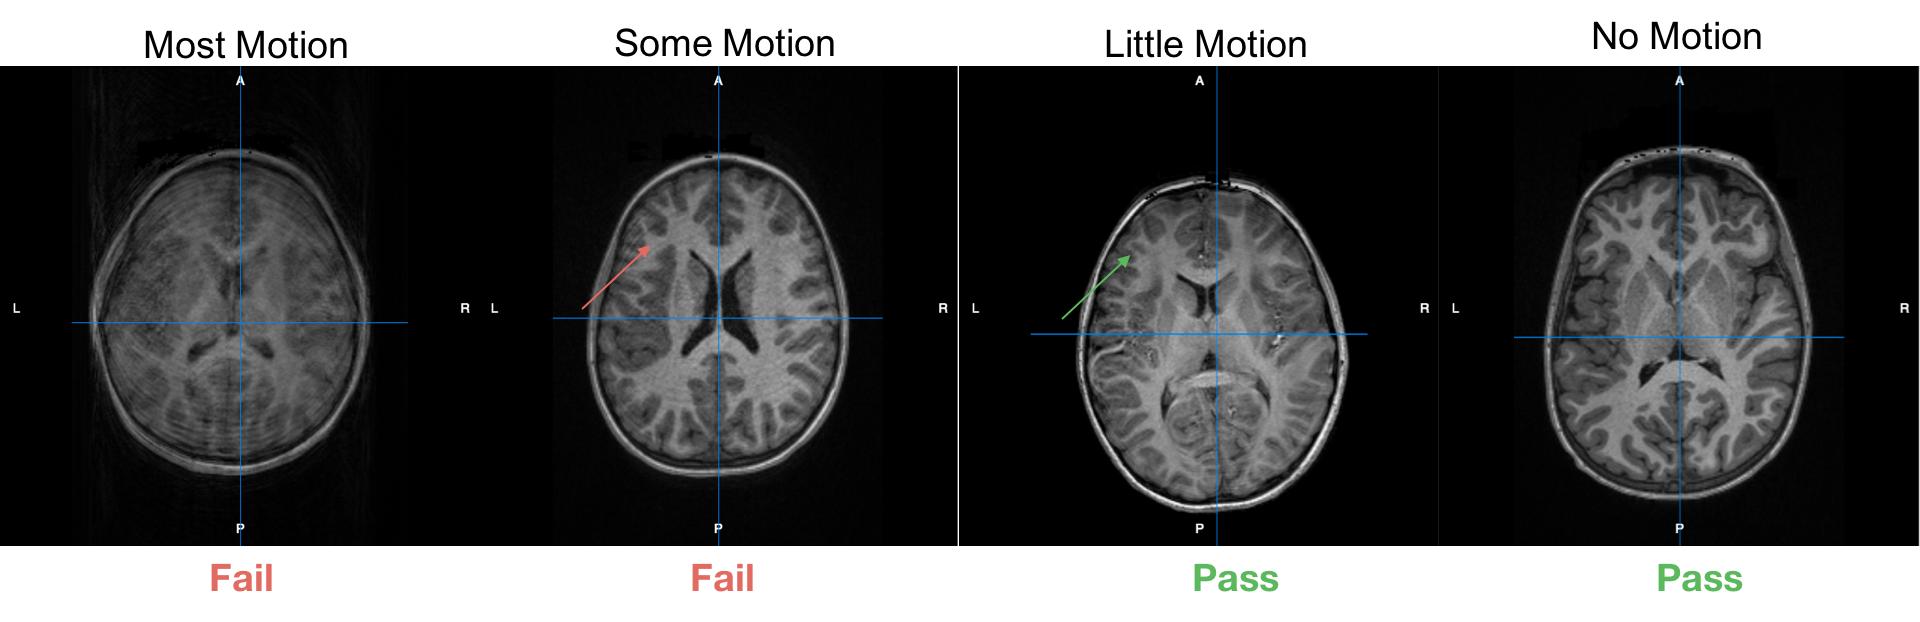

In [2]:
from IPython.display import Image
Image("http://mindcontrol-hbn.herokuapp.com/motion_QC.png")

### Get Mindcontrol Data & Gold Standard

In [3]:
import os

In [4]:
labels = ba.get_truth_labels(os.path.join(ba.__path__[0],"data/mindcontrol-feb-21-18_anon.json"))

In [5]:
print("num failed images", np.unique(labels['failing_names']).shape[0])
print("num passing images", np.unique(labels['passing_names']).shape[0])

num failed images 94
num passing images 106


Check to see how well the raters agree w/ each other via ROC against the majority rater (anisha)

In [6]:
mindcontrol_df = pd.DataFrame(json.loads(labels['tidy_df']))
golden = mindcontrol_df[mindcontrol_df.checkedBy.isin(["anisha", "dnkennedy", "amandae", "62442katieb"])]
mcpv = golden.pivot_table(index='name', columns='checkedBy', values='score')

In [7]:
from sklearn.metrics import roc_curve, auc

def get_metric(name1, name2):
    a = mcpv[[name1, name2]].dropna()
    b = (a[name1] > 0).astype(float)
    fpr, tpr, _ = roc_curve(b, a[name2])
    return auc(fpr, tpr), a.shape[0]

In [8]:
aucs = []
nums = []
names = []
for i, col in enumerate(mcpv.columns):
    if (col != 'anisha'):
        a, b = get_metric(col, 'anisha')
        aucs.append(a)
        nums.append(b)
        names.append(col)
print(pd.DataFrame({'auc': aucs, 'n': nums, 'name': names}))

        auc   n         name
0  0.962821  41  62442katieb
1  0.977778  14      amandae
2  0.991304  28    dnkennedy


The weighted average by number of commonly rated images to anisha is:

In [9]:
np.average(aucs, weights=nums)

0.974952429562173

#### Calculate some summary metrics of the mindcontrol voting

In [10]:
stage1 = mindcontrol_df.groupby(['name','checkedBy']).apply(lambda x: x.mean()[['score']]).reset_index()
stage2 = stage1.groupby('name').apply(lambda x: x.mean()[['score']])
counts = stage1.groupby('name').apply(lambda x: x.count()[['score']])

In [11]:
counts.describe()

,score
count,724.000000
mean,1.494475
std,0.634397
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,7.000000


## Mindcontrol Rating Distributions

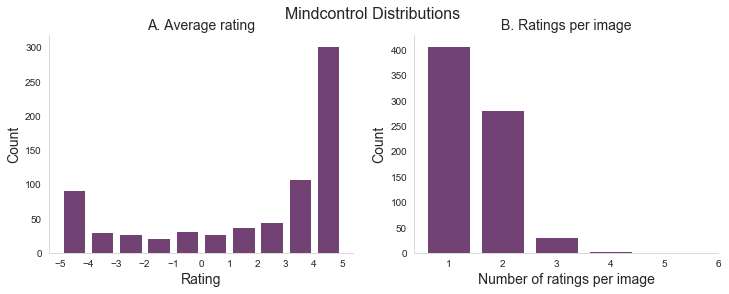

In [12]:
sns.set_style('white')
sns.set_palette(sns.color_palette("Set2", 10))
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.despine(fig)
colors = sns.cubehelix_palette(10, light=1)[::-1]

ax[0].spines['bottom'].set_color('lightgray')
ax[0].spines['left'].set_color('lightgray')
ax[1].spines['bottom'].set_color('lightgray')
ax[1].spines['left'].set_color('lightgray')

c,x,bars = ax[0].hist(stage2.score.values, rwidth=0.8, bins=10, color=colors[2]);
ax[0].set_xlabel('Rating', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
#ax[0].set_xticks([-4.5, -3.5, -2.5, -1.5, -0.5, 0, 0.5,  1.5,  2.5,  3.5,  4.5,  5.5])
ax[0].set_xticks([-5, -4, -3, -2, -1,  0, 1,  2,  3,  4,  5])
ax[0].set_title('A. Average rating', fontsize=14)

ax[1].hist(counts.score.values, rwidth=0.8, bins = range(1,counts.score.max()), color=colors[2])
ax[1].set_ylabel('Count', fontsize=14)
ax[1].set_title('B. Ratings per image', fontsize=14)
ax[1].set_xlabel('Number of ratings per image', fontsize=14)
ax[1].set_xticks(np.arange(1, counts.score.max())+0.5)
ax[1].set_xticklabels(np.arange(1, counts.score.max()))

plt.suptitle('Mindcontrol Distributions', fontsize=16);
plt.savefig('MindcontrolDistributions.svg')

consolidate data for this image

In [13]:
data_mindcontrol_figure = {}
data_mindcontrol_figure['average_rating'] = stage2.reset_index().to_dict(orient="records")
data_mindcontrol_figure['n_ratings_per_image'] = counts.reset_index().to_dict(orient="records")

In [14]:
from nipype.utils.filemanip import save_json
save_json("data_mindcontrol_figure.json", data_mindcontrol_figure)

### get & aggregate braindr data

In [15]:
braindr_path = "https://dxugxjm290185.cloudfront.net/braindr_data/braindr_data_2-27-18.csv"

learning_rate = [0.01, 0.1]
n_estimators = [600]
max_depth = [2, 6]
test_size = 0.33

post_data = {"braindr_data": braindr_path,
             "pass_labels": labels['passing_names'],
             "fail_labels": labels['failing_names'],
             "learning_rates": learning_rate, 
             "n_estimators": n_estimators, 
             "max_depth": max_depth,
             "test_size": test_size}

agg_data = ba.aggregate_braindr_votes(braindr_path, 
                                      labels['passing_names'], 
                                      labels['failing_names'],
                                      learning_rate, n_estimators, 
                                      max_depth, test_size)

/Users/anisha.keshavan/anaconda3/lib/python3.6/site-packages/braindrAnalysis-0.1.dev0-py3.6.egg/braindrAnalysis/braindrAnalysis.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  braindr_df_pass_subset['truth'] = 1
/Users/anisha.keshavan/anaconda3/lib/python3.6/site-packages/braindrAnalysis-0.1.dev0-py3.6.egg/braindrAnalysis/braindrAnalysis.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  braindr_df_fail_subset['truth'] = 0
/Users/anisha.keshavan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: Deprecati

In [16]:
bdr_all = pd.read_csv(braindr_path, index_col=0)
bdr_full = pd.DataFrame(json.loads(agg_data['output']))
bdr_full['subject_id'] = bdr_full.index.map(lambda x: x.split("__")[0])
bdr_gold = pd.DataFrame(json.loads(agg_data['bdr_pivot']))

## Sample Images

In [17]:
np.random.seed(0)

In [18]:
def get_image(img):
    url = "https://s3-us-west-2.amazonaws.com/akeshavan-mindcontrol/braindr/{}.jpg".format(img)
    urllib.request.urlretrieve(url, 'tmp.jpg')
    return plt.imread('tmp.jpg')

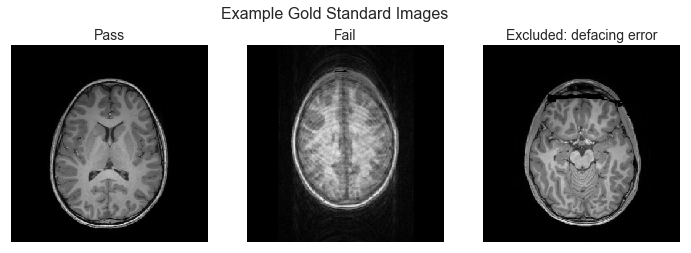

In [19]:
bad_deface = get_image(bdr_full[bdr_full.subject_id.isin(['sub-NDARWM527PRT_T1w'])].index.values[2])
good_ex = get_image(bdr_gold[bdr_gold.truth==1].index.values[10])
bad_ex = get_image(bdr_gold[bdr_gold.truth==0].index.values[10])

fig, ax = plt.subplots(1,3, figsize=(12,4))
sns.despine(fig, top=True, bottom=True, right=True, left=True)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].imshow(good_ex)
ax[0].set_title("Pass", fontsize=14)

ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(bad_ex)
ax[1].set_title("Fail", fontsize=14)

ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title("Excluded: defacing error", fontsize=14)
ax[2].imshow(bad_deface);

plt.suptitle('Example Gold Standard Images', fontsize=16);
plt.savefig('ExampleGoldStandardImages.svg')

## Gold Standard Distributions

In [20]:
#remove a few non-rater columns from the bdr_gold dataframe
bdr_raters_df = bdr_gold[[c for c in bdr_gold.columns if not c in ['truth', 'plain_average']]]
# get a list of raters
bdr_raters = bdr_raters_df.columns
total_num_users = np.unique(bdr_all.username.values).shape[0]
print("Total Number of Users:", total_num_users)
print("Number of Gold Standard Raters: ", len(bdr_raters))
# filter the original dataframe for only these raters
bdr_raters_only = bdr_all[bdr_all.username.isin(bdr_raters)]
print("Total Number of Ratings: ", bdr_all.shape[0])
print("Number of Ratings from Gold Standard Raters: ", bdr_raters_only.shape[0])
#filter the original dataframe for raters & gold images
bdr_raters_gold = bdr_raters_only[bdr_raters_only.image_id.isin(bdr_gold.index)]
print("Number of Ratings on Gold Standard Images:", bdr_raters_gold.shape[0])

Total Number of Users: 261
Number of Gold Standard Raters:  65
Total Number of Ratings:  83164
Number of Ratings from Gold Standard Raters:  68314
Number of Ratings on Gold Standard Images: 18940


In [21]:
braindr_stats_dataset = {"Total Number of Users:": total_num_users,
    "Number of Gold Standard Raters: ": len(bdr_raters),
    "Total Number of Ratings: ": bdr_all.shape[0],
    "Number of Ratings from Gold Standard Raters: ": bdr_raters_only.shape[0],
    "Number of Ratings on Gold Standard Images:": bdr_raters_gold.shape[0]}

In [22]:
from nipype.utils.filemanip import save_json
save_json("braindr_stats_dataset.json", braindr_stats_dataset)

In [23]:
mean_ratings = bdr_gold['plain_average']
counts_bdr = bdr_raters_gold.groupby('image_id').apply(lambda x: x.shape[0])

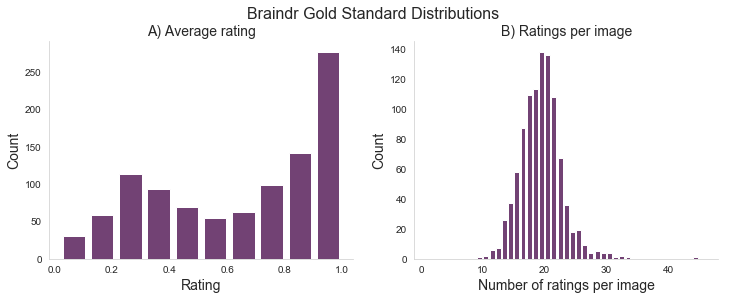

In [24]:
sns.set_style('white')
colors = sns.cubehelix_palette(10, light=1)[::-1]
# sns.set_palette(sns.color_palette("Set2", 10))
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].spines['bottom'].set_color('lightgray')
ax[0].spines['left'].set_color('lightgray')
ax[1].spines['bottom'].set_color('lightgray')
ax[1].spines['left'].set_color('lightgray')
sns.despine(fig)
c,x,bars = ax[0].hist(mean_ratings.values, rwidth=0.8, bins=10, color=colors[2]);
ax[0].set_xlabel('Rating', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
#ax[0].set_xticks([-4.5, -3.5, -2.5, -1.5, -0.5, 0, 0.5,  1.5,  2.5,  3.5,  4.5,  5.5])
#ax[0].set_xticks([-5, -4, -3, -2, -1,  0, 1,  2,  3,  4,  5])
ax[0].set_title('A) Average rating', fontsize=14)

ax[1].hist(counts_bdr.values, rwidth=0.8, bins = range(1,counts_bdr.values.max()), color=colors[2])
ax[1].set_title('B) Ratings per image', fontsize=14)
ax[1].set_xlabel('Number of ratings per image', fontsize=14)
ax[1].set_ylabel('Count', fontsize=14)

#ax[1].set_xticks(np.arange(1, counts.values.max())+0.5)
#ax[1].set_xticklabels(np.arange(1, counts.values.max()))

plt.suptitle('Braindr Gold Standard Distributions', fontsize=16, y=1);
plt.savefig('BraindrGoldStandardDistributions.svg')

In [25]:
braindr_distribution_dataset = {}
braindr_distribution_dataset['average_rating'] = mean_ratings.reset_index().to_dict(orient='records')
braindr_distribution_dataset['counts'] = counts_bdr.reset_index().to_dict(orient='records')
save_json('braindr_distribution_dataset.json', braindr_distribution_dataset)

In [26]:
from sklearn.metrics import roc_curve, auc

def get_roc_auc(agg_data):
    fpr, tpr, t = roc_curve(np.asarray(agg_data['y_test'])==1, np.asarray(agg_data['y_pred_prob']))
    a = auc(fpr, tpr)
    
    df = pd.DataFrame(json.loads(agg_data['bdr_pivot']))
    fprt, tprt, tt = roc_curve(df.truth.values == 1, df.plain_average.values)
    aa = auc(fprt, tprt)
    output = dict(fpr=fpr, tpr=tpr, thresholds=t, auc=a, train_size=agg_data['X_train_shape'][0],
                  fpr_a=fprt, tpr_a=tprt, thresholds_a = tt, auc_a = aa)
    return output

output = get_roc_auc(agg_data)
print(output['auc'])

0.9768847926267281


## Braindr aggregation via XGBoost: How much data is needed?

In [46]:
def iterate_test_size(test_size):
    import requests
    
    braindr_path = "https://dxugxjm290185.cloudfront.net/braindr_data/braindr_data_2-27-18.csv"

    learning_rate = [0.01, 0.1]
    n_estimators = [600]
    max_depth = [2, 6]

    agg_data = ba.aggregate_braindr_votes(braindr_path, 
                                      labels['passing_names'], 
                                      labels['failing_names'],
                                      learning_rate, n_estimators, 
                                      max_depth, test_size)
    return agg_data

In [47]:
test_sizes = [0.2, 0.33, 0.5, 0.75]

data_all = Parallel(n_jobs=2)(delayed(iterate_test_size)(i) for i in test_sizes)

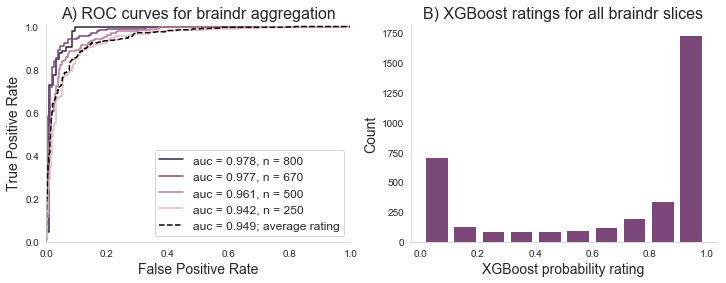

In [48]:
rocs = [get_roc_auc(d) for d in data_all]
#colors = sns.light_palette((210, 90, 60), input="husl")[::-1]
colors = sns.cubehelix_palette(5, light=1)[::-1]

with sns.color_palette(colors):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].spines['bottom'].set_color('lightgray')
    ax[0].spines['left'].set_color('lightgray')
    ax[1].spines['bottom'].set_color('lightgray')
    ax[1].spines['left'].set_color('lightgray')
    sns.despine(fig)
    for i, roc in enumerate(rocs):
        ax[0].plot(roc['fpr'], roc['tpr'])
        ax[0].set_xlim([0,1])
        ax[0].set_ylim([0,1.01])
        
    ax[0].plot(roc['fpr_a'], roc['tpr_a'], color="black", linestyle="--")
    ax[0].legend(["auc = %0.3f, n = %d" % (roc['auc'], 
                                        roc['train_size']) for roc in rocs] +\
              ["auc = %0.3f; average rating" % rocs[0]['auc_a']], loc=4, fontsize=12)
    ax[0].set_xlabel('False Positive Rate', fontsize=14)
    ax[0].set_ylabel('True Positive Rate', fontsize=14)
    ax[0].set_title("A) ROC curves for braindr aggregation", fontsize=16)
    
    output = pd.DataFrame(json.loads(agg_data['output']))
    ax[1].hist(output.xgboost_label.values, rwidth=0.8, color=colors[1])
    ax[1].set_xlabel('XGBoost probability rating', fontsize=14)
    ax[1].set_ylabel('Count', fontsize=14)
    ax[1].set_title('B) XGBoost ratings for all braindr slices', fontsize=16)

## XGBoost feature importances

Text(0.5, 0.98, 'Rater Importance from XGBoost Model')

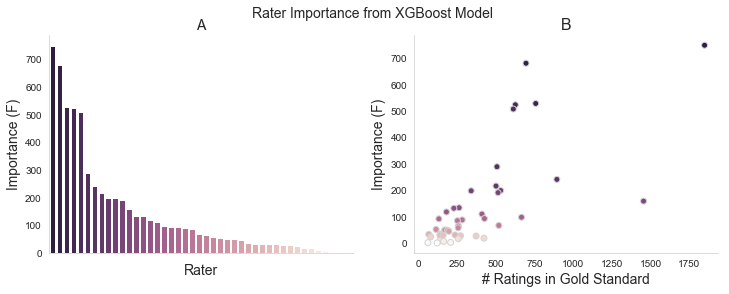

In [49]:
fdf = pd.DataFrame(json.loads(agg_data['user_importance']))
fdf.sort_values('F', inplace=True)
fdf.rename(columns={"user": "username"}, inplace=True)
fdf = fdf[::-1]
fdf['idx'] = np.arange(1, 1+fdf.shape[0])
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].spines['top'].set_visible(False)
#ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(True)

ax[0].spines['bottom'].set_color('lightgray')
ax[0].spines['left'].set_color('lightgray')
ax[1].spines['bottom'].set_color('lightgray')
ax[1].spines['left'].set_color('lightgray')

colors = sns.cubehelix_palette(fdf.shape[0], light=1)[::-1]

ax[0].bar(np.arange(fdf.shape[0]), fdf.F.values, color=colors)
ax[0].set_xticks(np.arange(fdf.shape[0]))
ax[0].set_xticklabels([]) #fdf.idx.values, fontsize=8);
#ax[0].set_yticks([])
ax[0].set_xlabel("Rater", fontsize=14)
ax[0].set_ylabel("Importance (F)", fontsize=14)
ax[0].set_xlim([-0.5,fdf.shape[0]])
ax[0].set_title("A", fontsize=14)


sns.despine(ax=ax[1])

ucounts = bdr_raters_gold.groupby('username').apply(lambda x: x.shape[0])
fdf.set_index('username', inplace=True)
fdf['ucounts'] = ucounts

ax[1].scatter(fdf.ucounts.values, fdf.F.values, c=colors, edgecolors="lightgray")
ax[1].set_xlabel("# Ratings in Gold Standard", fontsize=14)
ax[1].set_ylabel("Importance (F)", fontsize=14)
ax[1].set_title("B", fontsize=16)


from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

plt.suptitle("Rater Importance from XGBoost Model", fontsize=14)
#for i, row in fdf.iterrows():
#  ax.text(row.F+1, idx-0.15, str(row.F))
#  idx +=1

Make stuff JSON serializeable so we can share data in JSON format

In [50]:
for i, roc in enumerate(rocs):
    for key, value in roc.items():
        #rocs[i][key] 
        if isinstance(value, np.ndarray):
            rocs[i][key] = value.tolist()

In [51]:
braindr_xgboost_data = {}
braindr_xgboost_data['user_importances'] = fdf.astype(float).to_dict(orient='records')
braindr_xgboost_data['ratings'] = output[['xgboost_label']].reset_index().to_dict(orient='records')
braindr_xgboost_data['rocs'] = rocs
save_json("braindr_xgboost_data.json", braindr_xgboost_data)

## Deep Learning to predict XGBoost rating from slice

If you want the data, grab it from here: 

In [33]:
ba.using_GPU()

'/device:GPU:0'

In [53]:
# get the data from the OSF link
# https://osf.io/xn238/
urllib.request.urlretrieve("https://files.osf.io/v1/resources/j5d4y/providers/osfstorage/5aecb10458015f000f06db27", "braindr_slice_data.npz")

('braindr_slice_data.npz', <http.client.HTTPMessage at 0x1c3c8f1320>)

In [55]:
data = np.load('./braindr_slice_data.npz')
img_labels = pd.DataFrame(index=data['labels'])
             #pd.read_csv('https://s3-us-west-2.amazonaws.com/akeshavan-mindcontrol/braindr/braindr-1-26.csv', 
             #            index_col=0)
img_labels['y_prob'] = output.xgboost_label
img_labels['subject'] = img_labels.index.map(lambda x:x.split("__")[0])

#### Note: the 256x256 slice data was run though the vgg model and saved (because this takes a long time)
```python
from skimage.color import gray2rgb
vgg_model = applications.VGG16(include_top=False, weights='imagenet', 
                           input_shape=(256,256,3))
# where X_rgb is data['X'] converted to rgb with skimage
X_vgg = vgg_model.predict(X_rgb)```

In [56]:
bin_idx = img_labels.subject.isin(labels['not_including']) == False
img_labels = img_labels[bin_idx]
X_vgg = data['X_vgg'][bin_idx]
y = img_labels['y_prob']

In [57]:
img_labels['idx'] = np.arange(img_labels.shape[0])
gold = pd.merge(img_labels[['idx']], bdr_gold[['truth', 'plain_average']], 
                left_index=True, right_index=True)

In [60]:
!mkdir scratch/braindr_vgg16

In [ ]:
results = ba.run_model(X_vgg, y, img_labels, gold, out_path="./scratch/braindr_vgg16")

Train on 2857 samples, validate on 360 samples
Epoch 1/50


In [38]:
all_predicted = results['model'].predict(X_vgg)

In [39]:
img_labels['predicted_label'] = all_predicted

In [41]:
all_results = []

for i in range(1,10):
    r = ba.run_model(X_vgg, y, img_labels, gold, out_path="/mnt/scratch3/keshavan/braindr_vgg16", i=i)
    all_results.append(r)

Train on 2857 samples, validate on 360 samples
Epoch 1/50
2857/2857 [==============================] - 2s 750us/step - loss: 0.0935 - acc: 0.0000e+00 - val_loss: 0.0697 - val_acc: 0.0000e+00
Epoch 2/50
2857/2857 [==============================] - 1s 448us/step - loss: 0.0706 - acc: 0.0000e+00 - val_loss: 0.0521 - val_acc: 0.0000e+00
Epoch 3/50
2857/2857 [==============================] - 1s 430us/step - loss: 0.0650 - acc: 0.0000e+00 - val_loss: 0.0471 - val_acc: 0.0000e+00
Epoch 4/50
2857/2857 [==============================] - 1s 418us/step - loss: 0.0600 - acc: 0.0000e+00 - val_loss: 0.0457 - val_acc: 0.0000e+00
Epoch 5/50
2857/2857 [==============================] - 1s 442us/step - loss: 0.0585 - acc: 0.0000e+00 - val_loss: 0.0479 - val_acc: 0.0000e+00
Epoch 6/50
2857/2857 [==============================] - 1s 426us/step - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0518 - val_acc: 0.0000e+00
Epoch 7/50
2857/2857 [==============================] - 1s 429us/step - loss: 0.0581 - ac

/home/keshavan/braindr-analysis/braindrAnalysis/braindrDL.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gold_in['y_pred'] = y_gold_pred


Train on 2858 samples, validate on 359 samples
Epoch 1/50
2858/2858 [==============================] - 2s 770us/step - loss: 0.0905 - acc: 0.0000e+00 - val_loss: 0.0672 - val_acc: 0.0000e+00
Epoch 2/50
2858/2858 [==============================] - 1s 410us/step - loss: 0.0682 - acc: 0.0000e+00 - val_loss: 0.0688 - val_acc: 0.0000e+00
Epoch 3/50
2858/2858 [==============================] - 1s 414us/step - loss: 0.0636 - acc: 0.0000e+00 - val_loss: 0.0586 - val_acc: 0.0000e+00
Epoch 4/50
2858/2858 [==============================] - 1s 456us/step - loss: 0.0623 - acc: 0.0000e+00 - val_loss: 0.0588 - val_acc: 0.0000e+00
Epoch 5/50
2858/2858 [==============================] - 1s 410us/step - loss: 0.0602 - acc: 0.0000e+00 - val_loss: 0.0602 - val_acc: 0.0000e+00
Epoch 6/50
2858/2858 [==============================] - 1s 429us/step - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0587 - val_acc: 0.0000e+00
Epoch 7/50
2858/2858 [==============================] - 1s 444us/step - loss: 0.0542 - ac

Epoch 12/50
2857/2857 [==============================] - 1s 410us/step - loss: 0.0510 - acc: 0.0000e+00 - val_loss: 0.0536 - val_acc: 0.0000e+00
Epoch 13/50
2857/2857 [==============================] - 1s 448us/step - loss: 0.0490 - acc: 0.0000e+00 - val_loss: 0.0689 - val_acc: 0.0000e+00
Epoch 14/50
2857/2857 [==============================] - 1s 430us/step - loss: 0.0495 - acc: 0.0000e+00 - val_loss: 0.0517 - val_acc: 0.0000e+00
Epoch 15/50
2857/2857 [==============================] - 1s 433us/step - loss: 0.0471 - acc: 0.0000e+00 - val_loss: 0.0504 - val_acc: 0.0000e+00
Epoch 16/50
2857/2857 [==============================] - 1s 449us/step - loss: 0.0476 - acc: 0.0000e+00 - val_loss: 0.0517 - val_acc: 0.0000e+00
Epoch 17/50
2857/2857 [==============================] - 1s 433us/step - loss: 0.0453 - acc: 0.0000e+00 - val_loss: 0.0642 - val_acc: 0.0000e+00
Epoch 18/50
2857/2857 [==============================] - 1s 409us/step - loss: 0.0445 - acc: 0.0000e+00 - val_loss: 0.0515 - val_a

2858/2858 [==============================] - 1s 429us/step - loss: 0.0425 - acc: 0.0000e+00 - val_loss: 0.0569 - val_acc: 0.0000e+00
Epoch 23/50
2858/2858 [==============================] - 1s 415us/step - loss: 0.0405 - acc: 0.0000e+00 - val_loss: 0.0494 - val_acc: 0.0000e+00
Epoch 24/50
2858/2858 [==============================] - 1s 427us/step - loss: 0.0394 - acc: 0.0000e+00 - val_loss: 0.0488 - val_acc: 0.0000e+00
Epoch 25/50
2858/2858 [==============================] - 1s 431us/step - loss: 0.0396 - acc: 0.0000e+00 - val_loss: 0.0482 - val_acc: 0.0000e+00
Epoch 26/50
2858/2858 [==============================] - 1s 464us/step - loss: 0.0387 - acc: 0.0000e+00 - val_loss: 0.0515 - val_acc: 0.0000e+00
Epoch 27/50
2858/2858 [==============================] - 1s 440us/step - loss: 0.0383 - acc: 0.0000e+00 - val_loss: 0.0492 - val_acc: 0.0000e+00
Epoch 28/50
2858/2858 [==============================] - 1s 416us/step - loss: 0.0382 - acc: 0.0000e+00 - val_loss: 0.0509 - val_acc: 0.0000e+

2857/2857 [==============================] - 1s 437us/step - loss: 0.0364 - acc: 0.0000e+00 - val_loss: 0.0533 - val_acc: 0.0000e+00
Epoch 33/50
2857/2857 [==============================] - 1s 445us/step - loss: 0.0353 - acc: 0.0000e+00 - val_loss: 0.0544 - val_acc: 0.0000e+00
Epoch 34/50
2857/2857 [==============================] - 1s 415us/step - loss: 0.0345 - acc: 0.0000e+00 - val_loss: 0.0517 - val_acc: 0.0000e+00
Epoch 35/50
2857/2857 [==============================] - 1s 406us/step - loss: 0.0344 - acc: 0.0000e+00 - val_loss: 0.0517 - val_acc: 0.0000e+00
Epoch 36/50
2857/2857 [==============================] - 1s 401us/step - loss: 0.0332 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 37/50
2857/2857 [==============================] - 1s 426us/step - loss: 0.0330 - acc: 0.0000e+00 - val_loss: 0.0520 - val_acc: 0.0000e+00
Epoch 38/50
2857/2857 [==============================] - 1s 465us/step - loss: 0.0319 - acc: 0.0000e+00 - val_loss: 0.0549 - val_acc: 0.0000e+

In [42]:
k = [a['auc'] for a in all_results + [results]]
print(np.mean(k), np.std(k))

0.9952615617187046 0.005285869147675219


In [43]:
a = all_results[0]['train_idx']
b = all_results[1]['train_idx']

In [44]:
# Make sure the training sets for different seed runs actually have different subjects
assert ~np.asarray([i in b for i in a]).all()

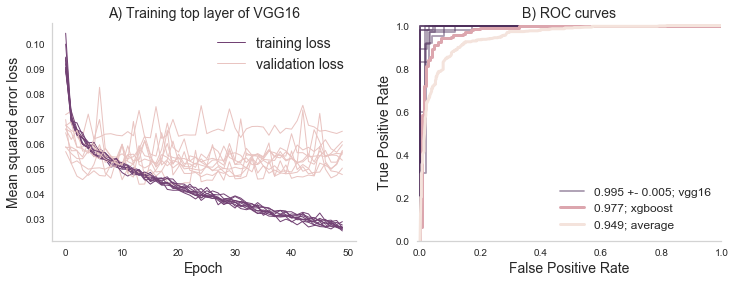

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].spines['bottom'].set_color('lightgray')
ax[0].spines['left'].set_color('lightgray')
ax[1].spines['bottom'].set_color('lightgray')
ax[1].spines['left'].set_color('lightgray')

colors = sns.cubehelix_palette(10, light=1)[::-1]

sns.despine(fig)
for i, a in enumerate(all_results + [results]):
    if not i:
        ax[1].plot(a['fpr'], a['tpr'], alpha=0.5, color=colors[1], 
                   label="%0.3f +- %0.3f; vgg16" % (np.mean(k), np.std(k)))
    else:
        ax[1].plot(a['fpr'], a['tpr'], alpha=0.5, color=colors[1])

    
    
ax[1].plot(rocs[1]['fpr'], rocs[1]['tpr'],color=colors[6], 
           label="%0.3f; xgboost" % rocs[1]['auc'], linewidth=3)
ax[1].plot(rocs[1]['fpr_a'], rocs[1]['tpr_a'], color=colors[8], 
           label="%0.3f; average" % rocs[1]['auc_a'], linewidth=3)
ax[1].set_xlim([-0.01,1])
ax[1].set_ylim([0,1.01])
ax[1].legend(fontsize=12, loc=4)
ax[1].spines['left'].set_visible(False)
ax[1].set_xlabel('False Positive Rate', fontsize=14)
ax[1].set_ylabel("True Positive Rate", fontsize=14)
ax[1].set_title("B) ROC curves", fontsize=14)
    
tdf = results['training']
ax[0].plot(tdf.epoch.values, tdf.loss.values, label="training loss", linewidth=1, color=colors[2])
ax[0].plot(tdf.epoch.values, tdf.val_loss.values, label="validation loss", linewidth=1, color=colors[7])
ax[0].legend(fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('Mean squared error loss', fontsize=14)
ax[0].set_title("A) Training top layer of VGG16", fontsize=14)

for res in all_results:
    tdf = res['training']
    ax[0].plot(tdf.epoch.values, tdf.loss.values, label="training loss", linewidth=1, color=colors[2])
    ax[0].plot(tdf.epoch.values, tdf.val_loss.values, label="validation loss", linewidth=1, color=colors[7])

In [46]:
results.keys()

dict_keys(['model', 'fpr', 'tpr', 'threshold', 'auc', 'training', 'best_model', 'train_shape', 'test_shape', 'val_shape', 'test_idx', 'train_idx', 'val_idx', 'gold_test', 'gold_idx'])

In [47]:
braindr_vgg_train = {'vgg': [], 'crowd': rocs[1]}
for a in all_results + [results]:
    entry = {}
    for key in ['fpr', 'tpr', 'threshold', 'auc']:
        try:
            entry[key] = a[key].tolist()
        except:
            entry[key] = a[key]
    entry['training'] = a['training'].to_json(orient="records")
    braindr_vgg_train['vgg'].append(entry)
save_json("../src/assets/braindr_vgg_results.json", braindr_vgg_train)

### Run XGBoost Model on MRIQC features

In [48]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


def run_XGmodel(X, y, test_size=0.33, seed=7):

    #seed = 7
    #test_size = 0.33

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        random_state=seed,
                                                        stratify=y)

    # make sure everyone has a vote in the train and test
    #assert(np.isfinite(X_train).sum(0).all())
    #assert(np.isfinite(X_test).sum(0).all())

    model = XGBClassifier()

    # parameters to tune
    learning_rate = [0.001, 0.01, 0.1]
    n_estimators = [200, 600]
    max_depth = [2, 6, 8]

    # run the grid search
    param_grid = dict(learning_rate=learning_rate,
                      max_depth=max_depth,
                      n_estimators=n_estimators)
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss",
                               n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X_train, y_train)

    # results

    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
    #    print(mean, stdev, param)

    # make predictions for test data
    # y_pred = model.predict(X_test)
    y_pred = grid_result.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    # log["Accuracy: %.2f%%"] = (accuracy * 100.0)
    print("accuracy", accuracy)

    y_pred_prob = grid_result.predict_proba(X_test)[:, 1]

    B = grid_result.best_estimator_.get_booster()
    fscores = B.get_fscore()
    fdf = pd.DataFrame([fscores]).T.rename(columns={0: 'F'})
    #print(fdf)
    fpr, tpr, _ = roc_curve(y_test==1, y_pred_prob)
    a = auc(fpr, tpr)
    

    return dict(fpr=fpr, tpr=tpr, auc=a, train_shape=X_train.shape[0], test_shape = X_test.shape[0], fscores=fdf, model=grid_result.best_estimator_)

## MRIQC

In [50]:
!wget https://cdn.rawgit.com/akeshavan/correlation-scatter/master/mridata.json

--2018-07-02 18:20:15--  https://cdn.rawgit.com/akeshavan/correlation-scatter/master/mridata.json
Resolving cdn.rawgit.com (cdn.rawgit.com)... 151.139.237.11
Connecting to cdn.rawgit.com (cdn.rawgit.com)|151.139.237.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘mridata.json’

    [   <=>                                 ] 2,447,424   5.19MB/s   in 0.5s   

2018-07-02 18:20:16 (5.19 MB/s) - ‘mridata.json’ saved [2447424]



In [51]:
from nipype.utils.filemanip import load_json
js = load_json("mridata.json")

In [52]:
mriqc = pd.DataFrame(js['points'])
mriqc['id'] = "sub-" + mriqc['id'] + "_T1w"
mriqc.set_index('id', inplace=True)

In [53]:
notinc = ['average_vote', 'group']
mriqc = mriqc[[c for c in mriqc.columns if not c in notinc]]
mriqc.shape

(727, 68)

In [54]:
mriqc_gold = mriqc[mriqc.index.isin(labels['passing_names'] + labels['failing_names'])]
mriqc_gold.loc[mriqc_gold.index.isin(labels['passing_names']), 'truth'] = 1
mriqc_gold.loc[mriqc_gold.index.isin(labels['failing_names']), 'truth'] = 0
#mriqc_gold.head()

/home/keshavan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/keshavan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [55]:
X_mriqc = mriqc_gold[mriqc_gold.columns[:-1]].values
y_mriqc = mriqc_gold.truth.values
run_XGmodel(X_mriqc, y_mriqc)


accuracy 0.9850746268656716


/home/keshavan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'auc': 0.9919642857142856,
 'fpr': array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.28125, 0.28125, 0.375  , 0.5    , 0.75   , 0.8125 , 0.84375,
        0.90625, 1.     ]),
 'fscores':       F
 f0   16
 f1    1
 f14  12
 f30   2
 f32  13
 f39   2
 f44   1
 f47   1
 f48   8
 f49   3
 f56   1
 f57  25
 f58  11
 f62  13
 f7   10
 f9    2,
 'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
        n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1),
 'test_shape': 67,
 'tpr': array([0.22857143, 0.34285714, 0.4       , 0.51428571, 0.62857143,
        0.71428571, 0.97142857, 0.97142857, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.      

In [56]:
mqc = []
for i in [0.33, 0.4, 0.5, 0.6, 0.7, 0.75, 0.78, 0.8, 0.85, 0.9, 0.96]:
    mqc.append(run_XGmodel(X_mriqc, y_mriqc, i))

accuracy 0.9850746268656716


/home/keshavan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy 0.9876543209876543


/home/keshavan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy 0.9801980198019802


/home/keshavan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy 0.9836065573770492


/home/keshavan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy 0.9577464788732394


/home/keshavan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy 0.9736842105263158


/home/keshavan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy 0.9683544303797469


/home/keshavan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy 0.9629629629629629


/home/keshavan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy 0.9244186046511628


/home/keshavan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy 0.8901098901098901


/home/keshavan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy 0.9278350515463918


/home/keshavan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [57]:
[a['train_shape'] for a in mqc]

[135, 121, 101, 80, 60, 50, 44, 40, 30, 20, 8]

In [58]:
[a['auc'] for a in mqc]

[0.9919642857142856,
 0.9957160342717258,
 0.9972419227738376,
 0.998110661268556,
 0.99681592039801,
 0.9956529299252304,
 0.9958172458172458,
 0.9960220318237454,
 0.9709673043006376,
 0.9688105620155039,
 0.928838152139123]

In [59]:
mriqc['mriqc_pred_xg'] = mqc[0]['model'].predict_proba(mriqc.values)[:,1]
mriqc.head()

,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,icvs_gm,...,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max,mriqc_pred_xg
id,,,,,,,,,,,,,,,,,,,,,
sub-NDARAA075AMK_T1w,0.401338,3.344635,0.572430,174.539413,3.085544,3.196753,3.154720,2.905160,0.185510,0.481902,...,1000.011719,163914.0,878.356732,1117.456946,73.577469,0.203075,0.528169,0.547186,0.661029,0.992338
sub-NDARAA536PTU_T1w,0.362474,3.621342,0.575308,473.510345,3.161872,3.351265,3.201410,2.932940,0.181488,0.476988,...,1000.018616,156213.0,870.229175,1102.131396,70.268486,0.182377,0.512774,0.516899,0.593028,0.995848
sub-NDARAA948VFH_T1w,0.297878,4.125184,0.545416,4884.107422,3.922949,3.929622,3.877175,3.962050,0.150669,0.510822,...,1000.017395,338940.0,894.432498,1079.413721,54.620735,0.216688,0.534772,0.524811,0.548028,0.995848
sub-NDARAC853DTE_T1w,0.676058,1.941620,0.550638,1023.677917,3.900360,4.012530,3.603725,4.084825,0.192333,0.441902,...,1000.080688,375876.0,865.664337,1187.690247,99.957100,0.184210,0.477631,0.482773,0.541348,0.006068
sub-NDARAC904DMU_T1w,0.566243,2.210376,0.622120,588.529785,4.179836,4.207371,4.046712,4.285425,0.209088,0.437881,...,1000.017944,353961.0,873.198547,1184.168823,96.117752,0.180289,0.470822,0.483930,0.533840,0.011922


Compute an overall 3D volume score from braindr so that MRIQC & Mindcontrol are comparible

In [61]:
def reshape_to_3D_labels(df):
    df['subject'] = df.index.map(lambda x: x.split("__")[0])
    df['slice_num'] = df.index.map(lambda x: int(x.split("_")[-1]))
    df.sort_values(['subject', 'slice_num'], inplace=True)
    for sub, subdf in df.groupby('subject'):
        df.loc[df.subject==sub, 'slice_idx'] = np.arange(subdf.shape[0]).tolist()
    return df
reshape_to_3D_labels(img_labels);


In [62]:
to3D = img_labels.pivot_table(columns=['slice_idx'], index=['subject'], values=['predicted_label'])
X_to3D = to3D['predicted_label'].values
print(X_to3D.shape)
#to3D['label_3D_xg'] = res_labelpred['model'].predict_proba(X_to3D)[:,1]
to3D['label_3D_avg'] = to3D['predicted_label'].mean(1)
to3D.head()

(715, 5)


predicted_label                                          \
slice_idx                        0.0       1.0       2.0       3.0       4.0   
subject                                                                        
sub-NDARAA075AMK_T1w        0.934165  0.938955  0.914462  0.901098  0.925164   
sub-NDARAA536PTU_T1w        0.989564  0.963793  0.972018  0.966510  0.954351   
sub-NDARAA948VFH_T1w        0.983284  0.988974  0.949114  0.984815  0.984098   
sub-NDARAC853DTE_T1w        0.074625  0.072041  0.005269  0.004604  0.022121   
sub-NDARAC904DMU_T1w        0.066431  0.027888  0.023215  0.004960  0.018744   

                     label_3D_avg  
slice_idx                          
subject                            
sub-NDARAA075AMK_T1w     0.922769  
sub-NDARAA536PTU_T1w     0.969247  
sub-NDARAA948VFH_T1w     0.978057  
sub-NDARAC853DTE_T1w     0.035732  
sub-NDARAC904DMU_T1w     0.028247

In [ ]:
#to3D['mriqc_pred_xg'] = mriqc['mriqc_pred_xg']

In [63]:
final_results = pd.merge(to3D, mriqc[['mriqc_pred_xg']], left_index=True, right_index=True)

/home/keshavan/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [64]:
final_results.rename(columns={('label_3D_avg', ''): 'label_3D_avg', 
                              ('mc_rating', ''): 'mc_rating',
                              ('predicted_label', 0.0): 'predicted_label-0',
                              ('predicted_label', 1.0): 'predicted_label-1',
                              ('predicted_label', 2.0): 'predicted_label-2',
                              ('predicted_label', 3.0): 'predicted_label-3',
                              ('predicted_label', 4.0): 'predicted_label-4',
                              
                             }, inplace=True)

In [65]:
final_results.head()

,predicted_label-0,predicted_label-1,predicted_label-2,predicted_label-3,predicted_label-4,label_3D_avg,mriqc_pred_xg
sub-NDARAA075AMK_T1w,0.934165,0.938955,0.914462,0.901098,0.925164,0.922769,0.992338
sub-NDARAA536PTU_T1w,0.989564,0.963793,0.972018,0.966510,0.954351,0.969247,0.995848
sub-NDARAA948VFH_T1w,0.983284,0.988974,0.949114,0.984815,0.984098,0.978057,0.995848
sub-NDARAC853DTE_T1w,0.074625,0.072041,0.005269,0.004604,0.022121,0.035732,0.006068
sub-NDARAC904DMU_T1w,0.066431,0.027888,0.023215,0.004960,0.018744,0.028247,0.011922


In [67]:
img_labels.head()

,y_prob,subject,idx,predicted_label,slice_num,slice_idx
sub-NDARAA075AMK_T1w__ax_71,0.082723,sub-NDARAA075AMK_T1w,3,0.934165,71,0.0
sub-NDARAA075AMK_T1w__ax_91,0.975416,sub-NDARAA075AMK_T1w,4,0.938955,91,1.0
sub-NDARAA075AMK_T1w__ax_111,0.986059,sub-NDARAA075AMK_T1w,0,0.914462,111,2.0
sub-NDARAA075AMK_T1w__ax_131,0.955134,sub-NDARAA075AMK_T1w,1,0.901098,131,3.0
sub-NDARAA075AMK_T1w__ax_151,0.659737,sub-NDARAA075AMK_T1w,2,0.925164,151,4.0


In [68]:
final_results['braindr_images'] = final_results.index.map(lambda x: img_labels[img_labels.subject==x].sort_values('slice_idx').index.values)

### todo: feature importance plot for mriqc

for example CJV is easy to split on:

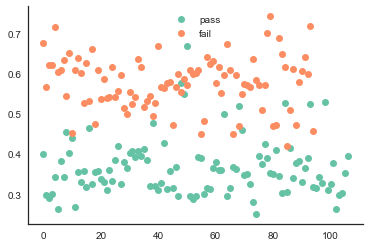

In [71]:
plt.plot(mriqc_gold[mriqc_gold.truth==1]['cjv'].values, lw=0, marker="o", label="pass")
plt.plot(mriqc_gold[mriqc_gold.truth==0]['cjv'].values, lw=0, marker="o", label="fail")
plt.legend()
sns.despine()